# Application to field data over Carajás Mineral Province, Brazil

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import pickle
import time

# 3D visualization
import pyvista as pv

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts
from gravmag import inverse_distance as idist

### Load data

In [2]:
with open('carajas_gz.pickle', 'rb') as f:
    carajas = pickle.load(f)

In [3]:
shape = (1000,500)

In [4]:
area = [np.min(carajas['x']), np.max(carajas['x']), np.min(carajas['y']), np.max(carajas['y'])]

In [5]:
area

[9102750.7, 9460499.3, 275977.47, 668999.71]

In [6]:
Lx = area[1] - area[0]
Ly = area[3] - area[2]

In [7]:
dx = np.mean(carajas['x'][500:5500:500] - carajas['x'][:5000:500])

In [8]:
dy = np.mean(carajas['y'][1:11] - carajas['y'][:10])

In [9]:
dx, dy

(358.10670670662074, 787.6197194388776)

In [10]:
data_mean = np.mean(carajas['gz'])
data_median = np.median(carajas['gz'])

In [11]:
data_max = np.max(carajas['gz'])
data_min = np.min(carajas['gz'])

In [12]:
carajas['x'][::shape[1]].shape

(1000,)

In [13]:
carajas['y'][:shape[1]].shape

(500,)

In [14]:
carajas['z'][:10]

array([-900., -900., -900., -900., -900., -900., -900., -900., -900.,
       -900.])

In [15]:
carajas_grid = {
    'x' : carajas['x'][::shape[1], np.newaxis],
    'y' : carajas['y'][:shape[1]],
    'z' : -900.,
    'ordering' : 'yx'
}

In [16]:
Q = shape[0] # number of blocks
P = shape[1] # number of points per block

### Plot data

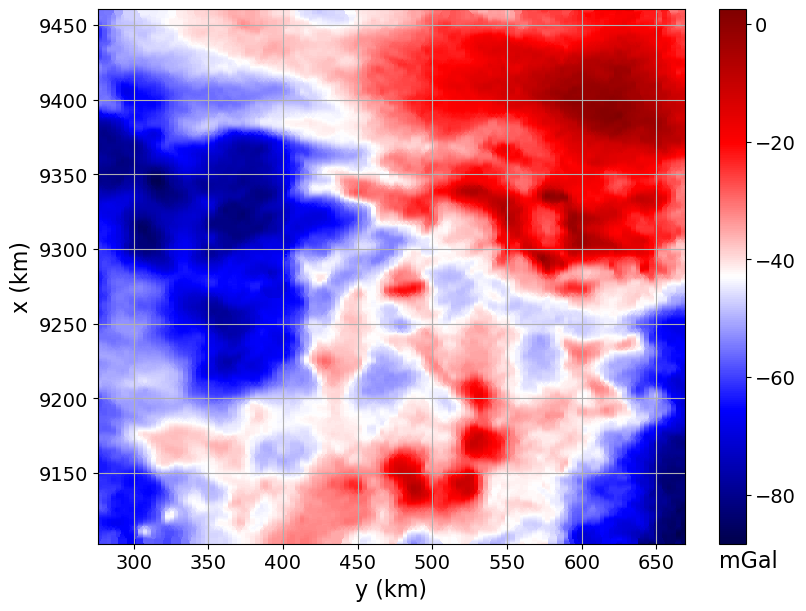

In [17]:
fig = plt.figure(layout= 'constrained', figsize=(8,6))
mosaic = fig.subplot_mosaic('''
                            a
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.pcolormesh(carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, carajas['gz'].reshape(shape),  
    cmap='seismic', vmin=data_min, vmax=data_max
)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
ax.set_ylim(0.001*area[0], 0.001*area[1])
ax.set_xlim(0.001*area[2], 0.001*area[3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

plt.savefig('../manuscript/Fig/carajas_data.png', dpi= 300)

plt.show()

### Set the equivalent sources

In [18]:
# depth of the equivalent layer
Delta_z = 3*dy

### Estimate the physical-property distribution on the planar layer

In [19]:
start = time.time()

In [20]:
R2 = idist.sedm_BTTB(data_grid=carajas_grid, delta_z=Delta_z)

In [21]:
g0 = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
    idist.grad_BTTB(data_grid=carajas_grid, delta_z=Delta_z, SEDM=R2, components=['z'])[0]
)

In [22]:
BTTB = {
    "symmetry_structure": "symm",
    "symmetry_blocks": "symm",
    "nblocks": Q,
    "columns": np.reshape(g0, (Q, P)),
    "rows": None,
}

In [23]:
# physical-property distribution
convergence, parameters = eql.method_iterative_deconvolution_TOB20(
    sensitivity_matrices=[BTTB], data_vectors=[carajas['gz']], epsilon=1e-3, ITMAX=50, check_input=True
    )

In [24]:
end = time.time()

In [25]:
print('Approximately {} s'.format(end-start))

Approximately 3.410224437713623 s


In [26]:
iterations = [i for i in range(len(convergence))]

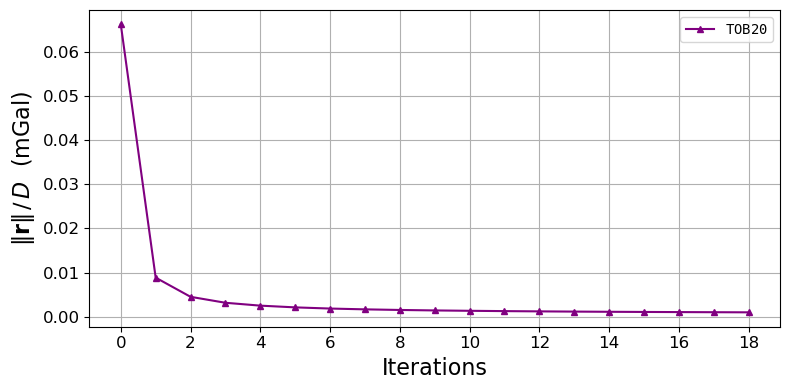

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(iterations[::2])
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../manuscript/Fig/convergence_carajas.png', dpi= 300)
plt.show()

In [28]:
predicted_data = dict()

In [29]:
# data predicted by the estimated equivalent layer
predicted_data['gz'] = conv.product_BCCB_vector(
    eigenvalues=conv.eigenvalues_BCCB(BTTB=BTTB, ordering="row"), ordering="row", v=parameters
)

In [30]:
# residuals vector
residuals_data = predicted_data['gz'] - carajas['gz']

### Plot the data fit

In [31]:
ranges_data = np.max(np.abs(carajas['gz']))
ranges_res = 0.2*np.max(np.abs(residuals_data))

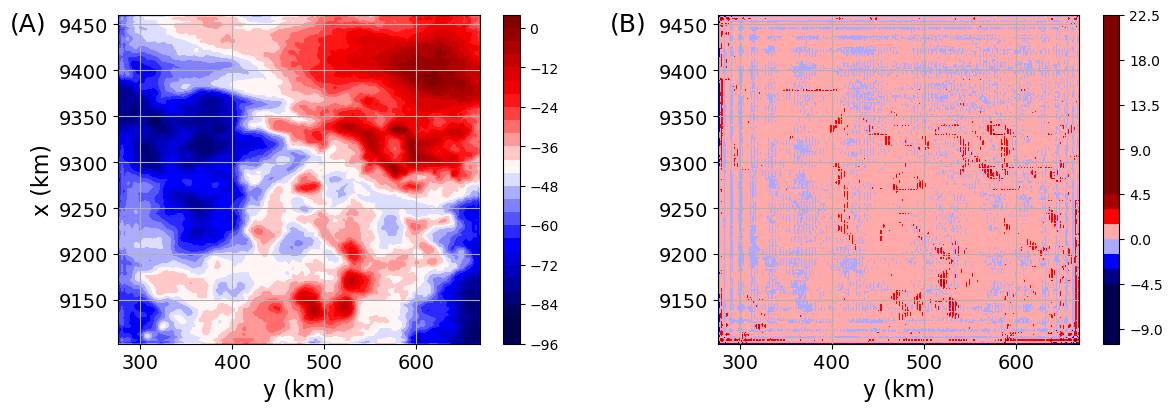

In [32]:
fig = plt.figure(layout= 'constrained', figsize=(12,4))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.contourf(carajas['y'].reshape(shape)*0.001, 
                 carajas['x'].reshape(shape)*0.001, 
                 predicted_data['gz'].reshape(shape), 30, 
                 cmap='seismic', vmin=data_min, vmax=data_max)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*area[0], 0.001*area[1])
ax.set_xlim(0.001*area[2], 0.001*area[3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(A)', xy=(-0.30, 0.95), xycoords='axes fraction', fontsize=18)
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

ax = mosaic['b']
ax.axis('scaled')
im = ax.contourf(carajas['y'].reshape(shape)*0.001, 
                 carajas['x'].reshape(shape)*0.001, 
                 residuals_data.reshape(shape), 30, 
                 cmap='seismic', vmin=-ranges_res, vmax=ranges_res)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*area[0], 0.001*area[1])
ax.set_xlim(0.001*area[2], 0.001*area[3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(B)', xy=(-0.30, 0.95), xycoords='axes fraction', fontsize=18)
#mosaic['b'].set_ylabel('x (km)', fontsize=16)
mosaic['b'].set_xlabel('y (km)', fontsize=16)

plt.show()

### Plot the residuals

In [33]:
tensor_components = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

symmetries_structure = [
    'symm', 'skew', 'skew',
    'symm', 'symm',
    'symm'
]

symmetries_blocks = [
    'symm', 'skew', 'symm',
    'symm', 'skew',
    'symm'
]

In [34]:
residuals = dict()
residuals['gz'] = residuals_data

# residuals tensor components
for (tensor_component, symmetry_structure, symmetry_blocks) in zip(tensor_components, symmetries_structure, symmetries_blocks):
    # kernel matrix associated with the equivalent layer
    g0 = cts.GRAVITATIONAL_CONST*cts.SI2EOTVOS*(
        idist.grad_tensor_BTTB(data_grid=carajas_grid, delta_z=Delta_z, SEDM=R2, components=[tensor_component])[0]
    )
    BTTB = {
        "symmetry_structure": symmetry_structure,
        "symmetry_blocks": symmetry_blocks,
        "nblocks": Q,
        "columns": np.reshape(g0, (Q, P)),
        "rows": None,
    }
    # data predicted by the estimated equivalent layer
    predicted_data['g{}'.format(tensor_component)] = conv.product_BCCB_vector(
        eigenvalues=conv.eigenvalues_BCCB(BTTB=BTTB, ordering="row"), ordering="row", v=parameters
    )

In [35]:
# compute ranges
ranges_tensor = []
for tensor_component in tensor_components:
    ranges_tensor.append(np.max(np.abs(predicted_data['g{}'.format(tensor_component)])))
ranges_tensor = 0.2*np.max(ranges_tensor)

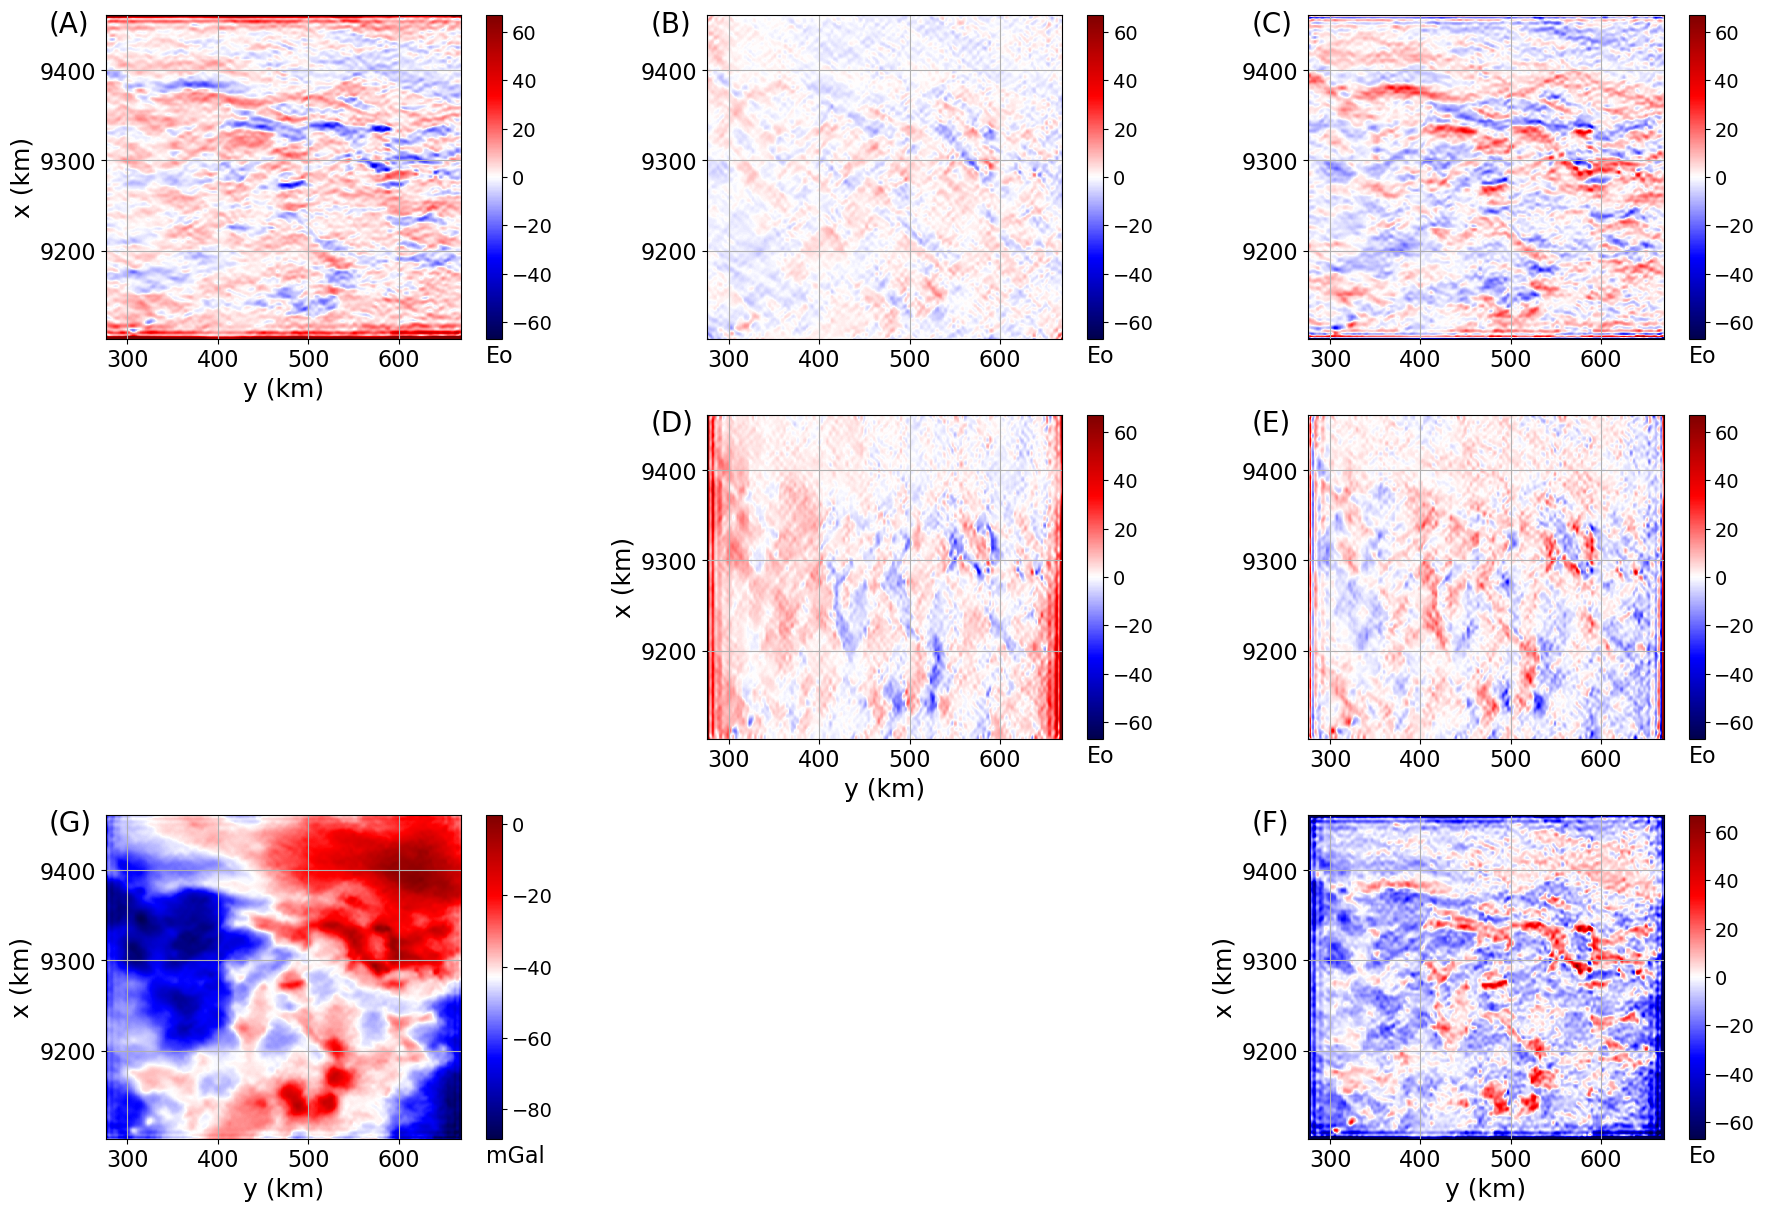

In [40]:
# plot figure
fig = plt.figure(layout= 'constrained', figsize=(18,12))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    # im = ax.contourf(carajas['y'].reshape(shape)*0.001, 
    #                  carajas['x'].reshape(shape)*0.001, 
    #                  predicted_data['g{}'.format(tensor_component)].reshape(shape), 20, 
    #                  cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    im = ax.pcolormesh(carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, predicted_data['g{}'.format(tensor_component)].reshape(shape),  
        cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor
    )
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('Eo', fontsize=16, loc='left')
    ax.set_ylim(0.001*area[0], 0.001*area[1])
    ax.set_xlim(0.001*area[2], 0.001*area[3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
ax.axis('scaled')
# im = ax.contourf(carajas['y'].reshape(shape)*0.001, 
#                  carajas['x'].reshape(shape)*0.001, 
#                  predicted_data['gz'].reshape(shape), 20, 
#                  cmap='seismic', vmin=data_min, vmax=data_max)
im = ax.pcolormesh(carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, predicted_data['gz'].reshape(shape),  
    cmap='seismic', vmin=data_min, vmax=data_max
)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
ax.set_ylim(0.001*area[0], 0.001*area[1])
ax.set_xlim(0.001*area[2], 0.001*area[3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)  

#plt.savefig('../manuscript/Fig/carajas_predicted.png', dpi= 300)
plt.show()

In [37]:
# compute mean and standard deviation
mean_gz = np.mean(residuals['gz'])
std_gz = np.std(residuals['gz'])

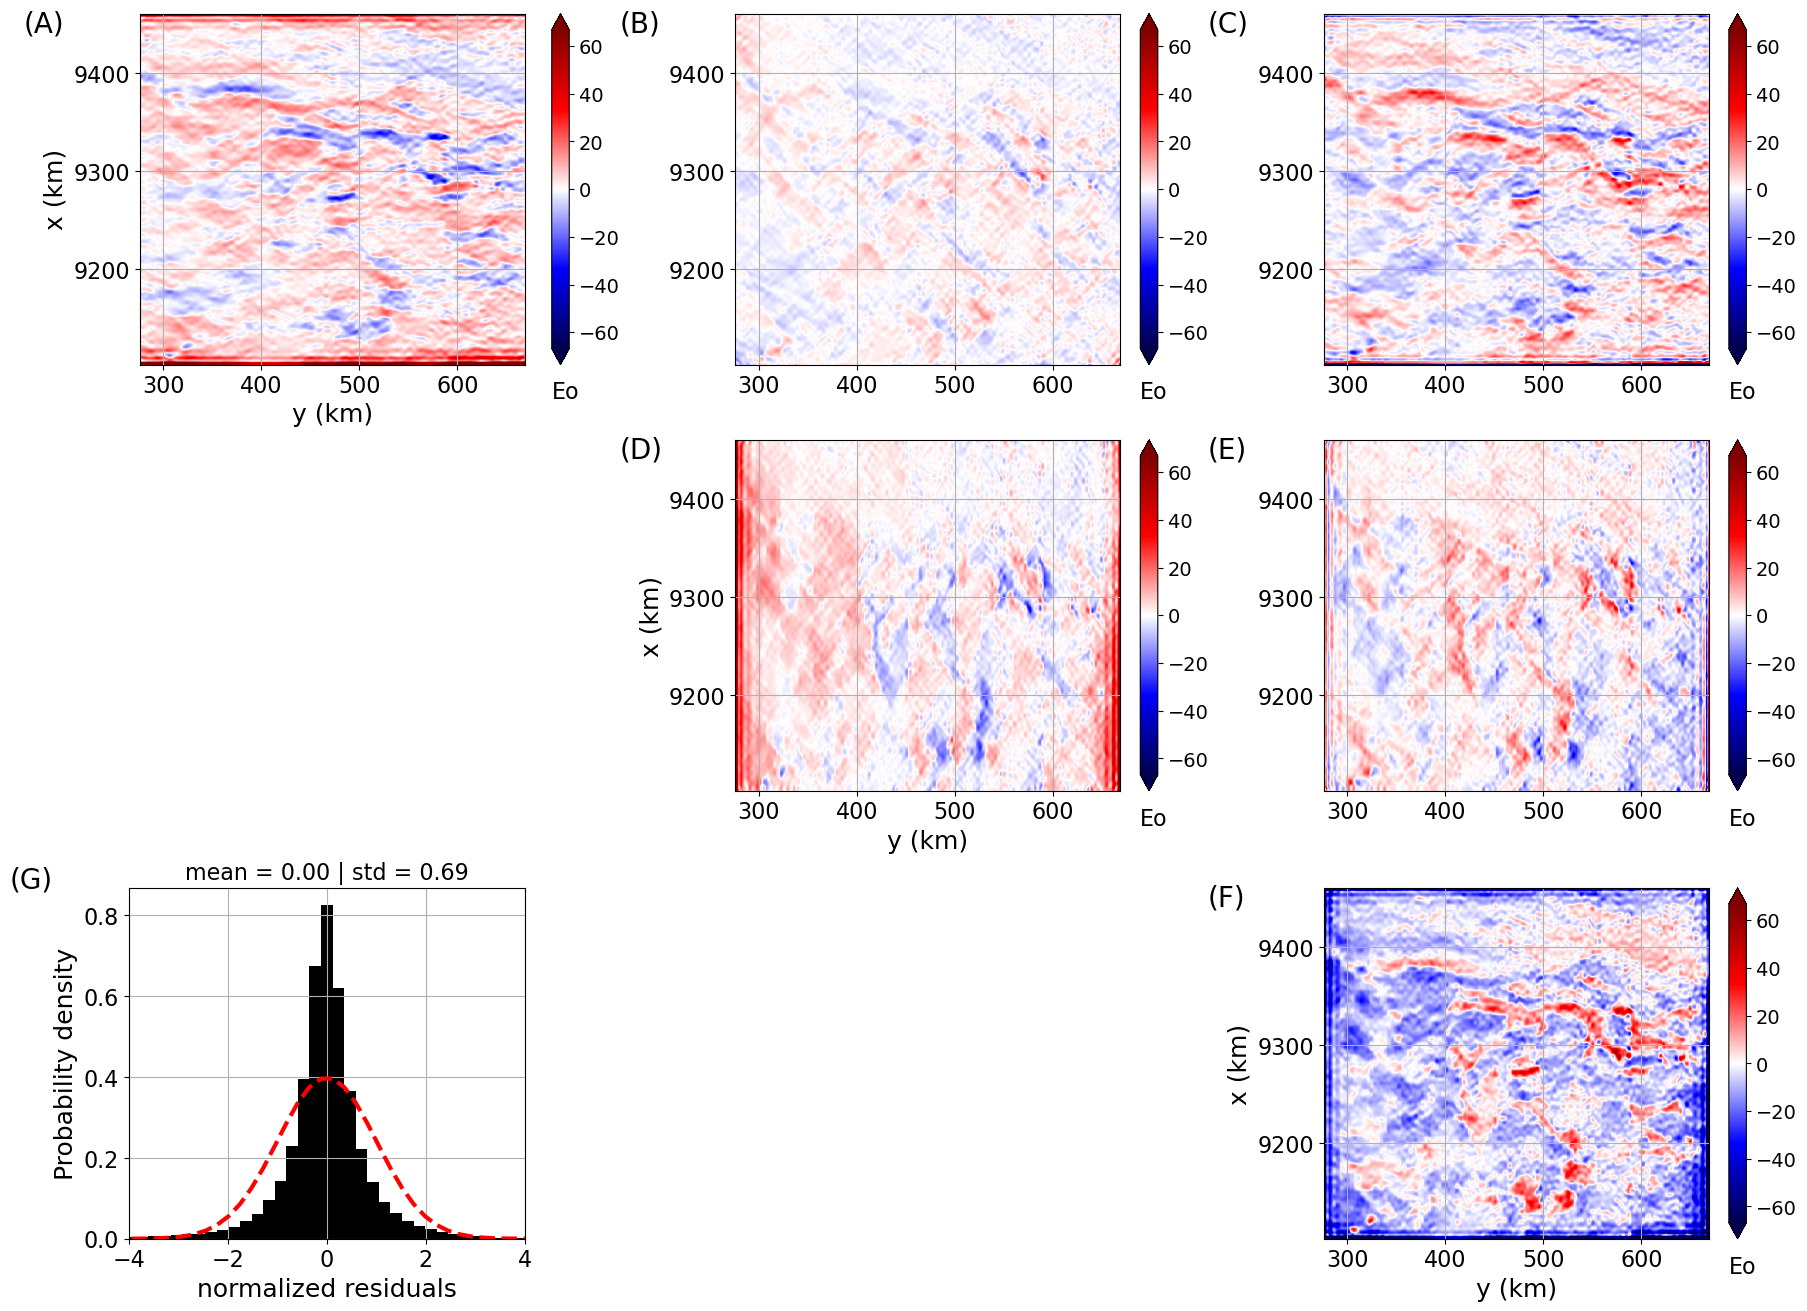

In [38]:
# plot figure

num_bins = 200

fig = plt.figure(layout= 'constrained', figsize=(18,13))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.pcolormesh(
        carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, 
        predicted_data['g{}'.format(tensor_component)].reshape(shape),  
        cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor
    )
    cb = fig.colorbar(im, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('\nEo', fontsize=16, loc='left')
    ax.set_ylim(0.001*area[0], 0.001*area[1])
    ax.set_xlim(0.001*area[2], 0.001*area[3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.30, 0.95), xycoords='axes fraction', fontsize=20)

# # gz
# ax = mosaic['g']
# ax.axis('scaled')
# im = ax.pcolormesh(
#     carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, 
#     residuals_data.reshape(shape),  
#     cmap='seismic', vmin=-ranges_res, vmax=ranges_res
# )
# cb = fig.colorbar(im, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=14)
# ax.set_ylim(0.001*area[0], 0.001*area[1])
# ax.set_xlim(0.001*area[2], 0.001*area[3])
# ax.tick_params(axis='x', labelsize=16)
# ax.tick_params(axis='y', labelsize=16)
# ax.grid()
# ax.annotate('(G)', xy=(-0.30, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)
    
# gz histogram
ax = mosaic['g']
# the histogram of the data
n, bins, patches = ax.hist(
    (residuals['gz'] - mean_gz)/std_gz, 
    num_bins, density=True, color='black'
)
# add a 'best fit' line
best_fit = (
    (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (bins)**2)
)
ax.plot(bins, best_fit, 'r--', linewidth=3)
ax.set_title('mean = {:.2f} | std = {:.2f}'.format(mean_gz, std_gz), fontsize=16)
ax.set_xlim(-4, 4)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.30, 1.00), xycoords='axes fraction', fontsize=20)
mosaic['g'].set_ylabel('Probability density', fontsize=18)
mosaic['g'].set_xlabel('normalized residuals', fontsize=18)

plt.savefig('../manuscript/Fig/carajas_grav_gradient.png', dpi= 300)
plt.show()